# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
from torchvision import datasets
import torchvision.transforms as transforms
BATCH_SIZE = 32
IMGS_MEAN = [0.485, 0.456, 0.406]
IMGS_STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=IMGS_MEAN, # Using means and stds from imagenet
                             std=IMGS_STD)


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize])


In [2]:
train_set = datasets.ImageFolder("/data/landmark_images/train", transform=transform) 

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
def train_val_split(dataset, batch_size=16, validation_split=.2, 
                    shuffle_dataset=True, random_seed=42):
    """
    Helper code adapted from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
    """
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler)
    
    validation_loader = torch.utils.data.DataLoader(dataset, 
                                                    batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader

train_loader, valid_loader = train_val_split(train_set, batch_size=BATCH_SIZE)

In [4]:
test_set = datasets.ImageFolder("/data/landmark_images/test", transform=transform)    

test_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE)

loaders_scratch = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}


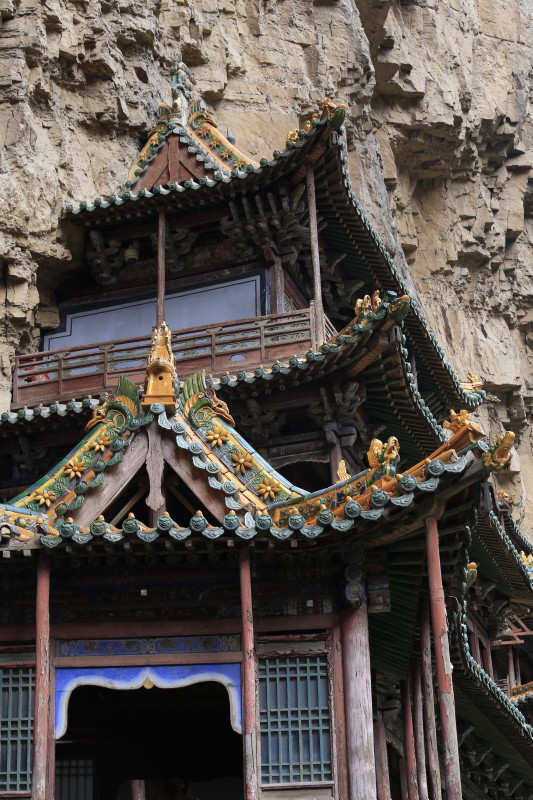

In [5]:
import glob, random
from PIL import Image
img_path = random.choice(glob.glob('/data/landmark_images/train/*/*.jpg'))
img = Image.open(img_path); img

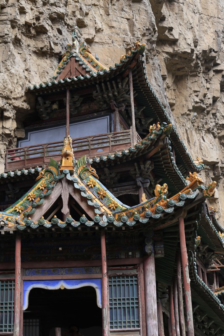

In [6]:
tr = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
])
tr(img)

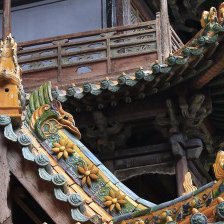

In [7]:
tr = transforms.Compose([
    #transforms.Resize(224),
    transforms.CenterCrop(224),
])
tr(img)

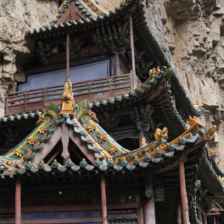

In [8]:
tr = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])
tr(img)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- The images have been Resized to 224 (i.e. the shortest edge has been reduced to 224px instead of the image being shrinked into a square of 224x224) followed by Center Crop of 224 pixels. 
- For simplicity I decided not to augment the dataset. The reason is because I want first a baseline score without that and then later, if necessary, I can compare with more advanced techniques. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

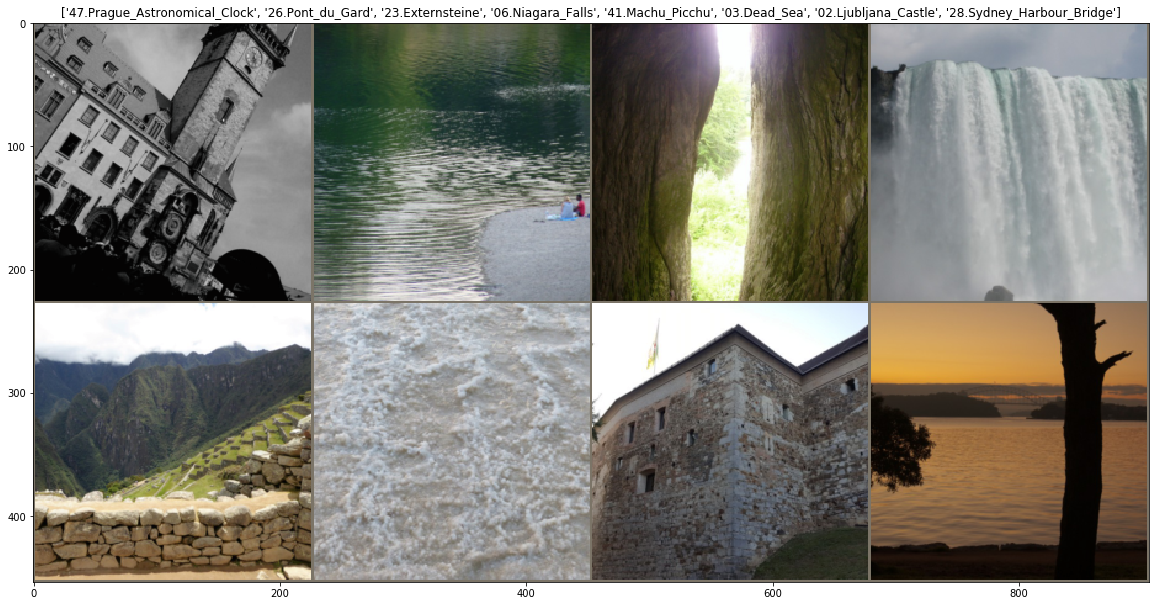

In [9]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

N_IMAGES = 8

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img, labels, classes):
    img = inverse_normalize(img, 
                            mean=IMGS_MEAN, 
                            std=IMGS_STD)
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title([classes[l] for l in labels])
    plt.show()

def show_imgs_from_batch(img_loader, n_imgs, img_set):
    dataiter = iter(img_loader)
    images, labels = dataiter.next()
    images, labels = images[:n_imgs], labels[:n_imgs]
    plt.figure(figsize=(20, 20))
    imshow(torchvision.utils.make_grid(images, nrow=4), labels, img_set.classes)

show_imgs_from_batch(train_loader, N_IMAGES, train_set)

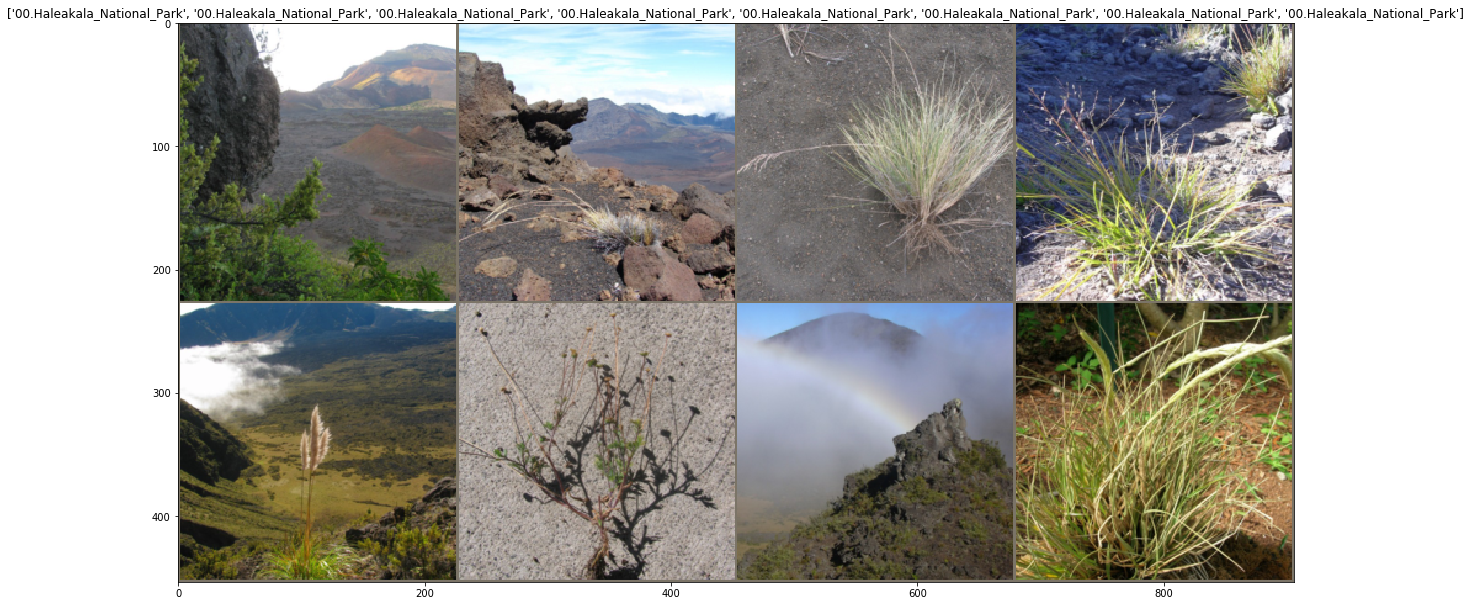

In [10]:
show_imgs_from_batch(test_loader, N_IMAGES, test_set)

### Initialize use_cuda variable

In [11]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [12]:
import torch.optim as optim
import torch.nn as nn

## select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model, lr=1e-3): # Adding learning rate for fine-tuning later
    ## select and return an optimizer
    optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=lr)
    return optimizer_scratch    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [13]:
n_classes=len(train_set.classes)
n_classes

50

In [14]:
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv = nn.Conv2d(3,16,5, stride=2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(55*55*16,50)     
    
    def forward(self, x):
        ## Define forward behavior
        x = self.maxpool(F.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I want to try the simplest model first in order to use as baseline. Hence, I selected one single conv layer with maxpool 2x2 followed by a Linear Layer. The kernel size is 5 as the first channel has bigger dimensions and I've selected stride=2 for saving computational power. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            print(f'Batch id {batch_idx}, Training Loss = {train_loss}')

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
                print(f'''Validation loss decreased from {valid_loss_min:.6f} to {valid_loss:.6f}. Saving model.''')
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [16]:
def custom_weight_init(m):
    ##implement a weight initialization strategy
    if isinstance(m, nn.Conv2d): # xavier uniform for the conv layers
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
        
    if isinstance(m, nn.Linear): #normal distribution when it is linear
        y = m.in_features
        m.weight.data.normal_(0.0,
                              1/np.sqrt(y)) 
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(3, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Batch id 0, Training Loss = 4.162134170532227
Batch id 1, Training Loss = 4.043323040008545
Batch id 2, Training Loss = 4.023732582728068
Batch id 3, Training Loss = 4.007790744304657
Batch id 4, Training Loss = 4.016383409500122
Batch id 5, Training Loss = 4.008849859237671
Batch id 6, Training Loss = 4.007618699754987
Batch id 7, Training Loss = 3.9968114495277405
Batch id 8, Training Loss = 3.9961966938442655
Batch id 9, Training Loss = 3.988043117523193
Batch id 10, Training Loss = 3.9857669310136274
Batch id 11, Training Loss = 3.974741816520691
Batch id 12, Training Loss = 3.962545339877789
Batch id 13, Training Loss = 3.9619142838886807
Batch id 14, Training Loss = 3.950221395492554
Batch id 15, Training Loss = 3.9584410339593887
Batch id 16, Training Loss = 3.952392956789802
Batch id 17, Training Loss = 3.9476120604409113
Batch id 18, Training Loss = 3.9385894599713778
Batch id 19, Training Loss = 3.9362573981285096
Batch id 20, Training Loss = 3.9361001650492353
Batch id 21, T

Batch id 45, Training Loss = 3.463905350021694
Batch id 46, Training Loss = 3.4689242180357587
Batch id 47, Training Loss = 3.4665303130944567
Batch id 48, Training Loss = 3.470266955239432
Batch id 49, Training Loss = 3.474359254837036
Batch id 50, Training Loss = 3.469580383861766
Batch id 51, Training Loss = 3.4709273026539726
Batch id 52, Training Loss = 3.474463548300401
Batch id 53, Training Loss = 3.474182614573726
Batch id 54, Training Loss = 3.4783473058180374
Batch id 55, Training Loss = 3.474702409335545
Batch id 56, Training Loss = 3.4746049370682033
Batch id 57, Training Loss = 3.474456466477493
Batch id 58, Training Loss = 3.474866806450537
Batch id 59, Training Loss = 3.475925250848135
Batch id 60, Training Loss = 3.4769867717242637
Batch id 61, Training Loss = 3.47761957876144
Batch id 62, Training Loss = 3.4770725189693397
Batch id 63, Training Loss = 3.47562300041318
Batch id 64, Training Loss = 3.476606662456806
Batch id 65, Training Loss = 3.475029190381368
Batch id

Batch id 90, Training Loss = 3.258273813750717
Batch id 91, Training Loss = 3.2581543637358616
Batch id 92, Training Loss = 3.25469619997086
Batch id 93, Training Loss = 3.2550329781593152
Batch id 94, Training Loss = 3.2501319157449813
Batch id 95, Training Loss = 3.2511062026023856
Batch id 96, Training Loss = 3.2510526573535086
Batch id 97, Training Loss = 3.2511530603681282
Batch id 98, Training Loss = 3.248169530521739
Batch id 99, Training Loss = 3.246863059997558
Batch id 100, Training Loss = 3.245636078390744
Batch id 101, Training Loss = 3.2464376898372866
Batch id 102, Training Loss = 3.2466522466789165
Batch id 103, Training Loss = 3.245531455828593
Batch id 104, Training Loss = 3.2468999158768423
Batch id 105, Training Loss = 3.2464551768212946
Batch id 106, Training Loss = 3.243784527912318
Batch id 107, Training Loss = 3.24300045437283
Batch id 108, Training Loss = 3.243329564365772
Batch id 109, Training Loss = 3.2460668823935768
Batch id 110, Training Loss = 3.246321832

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [17]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 3

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Batch id 0, Training Loss = 3.963850975036621
Batch id 1, Training Loss = 3.99538516998291
Batch id 2, Training Loss = 4.014782587687175
Batch id 3, Training Loss = 3.986504912376404
Batch id 4, Training Loss = 3.9946597099304197
Batch id 5, Training Loss = 3.9774711529413858
Batch id 6, Training Loss = 3.9814253193991522
Batch id 7, Training Loss = 3.988382488489151
Batch id 8, Training Loss = 3.987677971522013
Batch id 9, Training Loss = 3.9801257848739624
Batch id 10, Training Loss = 3.9810051267797295
Batch id 11, Training Loss = 3.978820701440175
Batch id 12, Training Loss = 3.9684318762559156
Batch id 13, Training Loss = 3.969104766845703
Batch id 14, Training Loss = 3.966271734237671
Batch id 15, Training Loss = 3.9587236493825912
Batch id 16, Training Loss = 3.9556358702042522
Batch id 17, Training Loss = 3.9604821337593927
Batch id 18, Training Loss = 3.952969588731465
Batch id 19, Training Loss = 3.950272405147553
Batch id 20, Training Loss = 3.9514351912907193
Batch id 21, T

Batch id 45, Training Loss = 3.4083217589751533
Batch id 46, Training Loss = 3.407891811208522
Batch id 47, Training Loss = 3.4058299710353213
Batch id 48, Training Loss = 3.406236984291855
Batch id 49, Training Loss = 3.4056370496749877
Batch id 50, Training Loss = 3.4030895279903035
Batch id 51, Training Loss = 3.4034040432709913
Batch id 52, Training Loss = 3.403357699232281
Batch id 53, Training Loss = 3.4057624251754195
Batch id 54, Training Loss = 3.405377821488814
Batch id 55, Training Loss = 3.400157655988421
Batch id 56, Training Loss = 3.404886986079969
Batch id 57, Training Loss = 3.404607604289877
Batch id 58, Training Loss = 3.401181766542338
Batch id 59, Training Loss = 3.401224939028422
Batch id 60, Training Loss = 3.4016156626529384
Batch id 61, Training Loss = 3.4008092226520663
Batch id 62, Training Loss = 3.399559024780516
Batch id 63, Training Loss = 3.401916518807411
Batch id 64, Training Loss = 3.405682112620427
Batch id 65, Training Loss = 3.40795801263867
Batch 

Batch id 90, Training Loss = 3.1587039114354734
Batch id 91, Training Loss = 3.160377665706303
Batch id 92, Training Loss = 3.159716598449215
Batch id 93, Training Loss = 3.155568244609427
Batch id 94, Training Loss = 3.154377121674387
Batch id 95, Training Loss = 3.1535532300670943
Batch id 96, Training Loss = 3.15524354915029
Batch id 97, Training Loss = 3.154251465992052
Batch id 98, Training Loss = 3.1569269016535597
Batch id 99, Training Loss = 3.153052725791931
Batch id 100, Training Loss = 3.1533692166356757
Batch id 101, Training Loss = 3.1521123787936043
Batch id 102, Training Loss = 3.1512757967976692
Batch id 103, Training Loss = 3.1520871267868924
Batch id 104, Training Loss = 3.155138735544114
Batch id 105, Training Loss = 3.1542927499087354
Batch id 106, Training Loss = 3.1560468495449174
Batch id 107, Training Loss = 3.156096456227479
Batch id 108, Training Loss = 3.159380258770164
Batch id 109, Training Loss = 3.1604502894661644
Batch id 110, Training Loss = 3.156421253

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.020514


Test Accuracy: 25% (1272/4996)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, # Using the same data loaders from the previous step
                   'valid': valid_loader, 
                   'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [20]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model, lr=1e-3): # Adding learning rate for fine-tuning later
    ## select and return an optimizer
    optimizer_transfer = optim.SGD(model.parameters(), lr=lr)
    return optimizer_transfer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [21]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture

def get_model_transfer(model_name='vgg16'):
    if model_name=='vgg16':
        model_transfer = models.vgg16(pretrained=True)

        # Freeze features parameters
        for param in model_transfer.features.parameters():
            param.require_grad = False

        n_inputs = model_transfer.classifier[6].in_features
        # Keeping unfrozen linear layers with Imagenet's weights as default and updating only last linear layer
        model_transfer.classifier[6] = nn.Linear(n_inputs, 50)
        
    return model_transfer


model_transfer = get_model_transfer('vgg16')


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I am using the VGG model with pretrained weights from ImageNet. The feature parameters were kept frozen and I am only replacing the last linear layer with a classifier of 50 different outputs (`nn.Linear(n_inputs, 50)`). The other classifier layers were kept unfrozen but with the Imagenet's weights as starting point. My reasoning here is that there's some semantic in the classifiers that I would like to use as well but fine tune to the Landmarks problem.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [22]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer = train(6, 
                       loaders_transfer, 
                       model_transfer, 
                       get_optimizer_transfer(model_transfer, lr=2e-2), #fine-tuned with lrfinder
                       criterion_transfer, 
                       use_cuda, 
                       'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Batch id 0, Training Loss = 4.086527347564697
Batch id 1, Training Loss = 3.9569958448410034
Batch id 2, Training Loss = 3.9604508876800537
Batch id 3, Training Loss = 3.9007903933525085
Batch id 4, Training Loss = 3.8828179359436037
Batch id 5, Training Loss = 3.896682103474935
Batch id 6, Training Loss = 3.830778053828648
Batch id 7, Training Loss = 3.767678916454315
Batch id 8, Training Loss = 3.6960773203108044
Batch id 9, Training Loss = 3.650871419906616
Batch id 10, Training Loss = 3.5951815735210073
Batch id 11, Training Loss = 3.5454651713371277
Batch id 12, Training Loss = 3.48576675928556
Batch id 13, Training Loss = 3.475144164902823
Batch id 14, Training Loss = 3.441463581720988
Batch id 15, Training Loss = 3.420202597975731
Batch id 16, Training Loss = 3.3641575785244213
Batch id 17, Training Loss = 3.339177555508084
Batch id 18, Training Loss = 3.318787072834216
Batch id 19, Training Loss = 3.2975497603416444
Batch id 20, Training Loss = 3.276572386423747
Batch id 21, Tr

Batch id 45, Training Loss = 1.1076553438020789
Batch id 46, Training Loss = 1.104769136043305
Batch id 47, Training Loss = 1.1107167030374208
Batch id 48, Training Loss = 1.112965415935127
Batch id 49, Training Loss = 1.1048427832126617
Batch id 50, Training Loss = 1.098608650413214
Batch id 51, Training Loss = 1.1104219899727747
Batch id 52, Training Loss = 1.1086458957420204
Batch id 53, Training Loss = 1.1071747872564528
Batch id 54, Training Loss = 1.1051237897439437
Batch id 55, Training Loss = 1.1130017031516348
Batch id 56, Training Loss = 1.116341995565515
Batch id 57, Training Loss = 1.117580589549295
Batch id 58, Training Loss = 1.1090579346074898
Batch id 59, Training Loss = 1.1029309978087745
Batch id 60, Training Loss = 1.092254116886952
Batch id 61, Training Loss = 1.0897993435782771
Batch id 62, Training Loss = 1.0954314536518521
Batch id 63, Training Loss = 1.0953500056639314
Batch id 64, Training Loss = 1.0926288384657639
Batch id 65, Training Loss = 1.094380151141773

Batch id 89, Training Loss = 0.66528653535578
Batch id 90, Training Loss = 0.6666399335468209
Batch id 91, Training Loss = 0.6667364346592324
Batch id 92, Training Loss = 0.6712210566125891
Batch id 93, Training Loss = 0.6732020355919576
Batch id 94, Training Loss = 0.6721974137582278
Batch id 95, Training Loss = 0.6703138121714196
Batch id 96, Training Loss = 0.6691039173873431
Batch id 97, Training Loss = 0.6655813601552225
Batch id 98, Training Loss = 0.6639730177744472
Batch id 99, Training Loss = 0.6640094828605653
Batch id 100, Training Loss = 0.6650493097777415
Batch id 101, Training Loss = 0.6648782970858556
Batch id 102, Training Loss = 0.6642801397055098
Batch id 103, Training Loss = 0.6665038105386955
Batch id 104, Training Loss = 0.6637596749124073
Batch id 105, Training Loss = 0.6618766742494872
Batch id 106, Training Loss = 0.6640338248738619
Batch id 107, Training Loss = 0.6649068558105716
Batch id 108, Training Loss = 0.6670599287256188
Batch id 109, Training Loss = 0.6

Batch id 4, Training Loss = 0.5561023861169815
Batch id 5, Training Loss = 0.5073454057176907
Batch id 6, Training Loss = 0.4913288205862045
Batch id 7, Training Loss = 0.44248554483056063
Batch id 8, Training Loss = 0.41518050597773654
Batch id 9, Training Loss = 0.4199530616402626
Batch id 10, Training Loss = 0.398128172213381
Batch id 11, Training Loss = 0.3776811671753724
Batch id 12, Training Loss = 0.3606612831354141
Batch id 13, Training Loss = 0.34557489837918964
Batch id 14, Training Loss = 0.3496861755847931
Batch id 15, Training Loss = 0.3562126196920872
Batch id 16, Training Loss = 0.385179365382475
Batch id 17, Training Loss = 0.39746595753563774
Batch id 18, Training Loss = 0.4022590000378458
Batch id 19, Training Loss = 0.39459324553608893
Batch id 20, Training Loss = 0.38573046028614044
Batch id 21, Training Loss = 0.3739789995280179
Batch id 22, Training Loss = 0.3678629009620003
Batch id 23, Training Loss = 0.3689609058201313
Batch id 24, Training Loss = 0.36739441752

Batch id 46, Training Loss = 0.2947680278027311
Batch id 47, Training Loss = 0.29024332575500006
Batch id 48, Training Loss = 0.28920799341737
Batch id 49, Training Loss = 0.2896313723921775
Batch id 50, Training Loss = 0.2930228724783541
Batch id 51, Training Loss = 0.3011548808560921
Batch id 52, Training Loss = 0.3040471231600023
Batch id 53, Training Loss = 0.30319817722947506
Batch id 54, Training Loss = 0.30538647256114265
Batch id 55, Training Loss = 0.3066394980996847
Batch id 56, Training Loss = 0.30595615584599345
Batch id 57, Training Loss = 0.3044006536746847
Batch id 58, Training Loss = 0.30370058346602874
Batch id 59, Training Loss = 0.3039202243089676
Batch id 60, Training Loss = 0.3073665177235838
Batch id 61, Training Loss = 0.306413626959247
Batch id 62, Training Loss = 0.3021769925715432
Batch id 63, Training Loss = 0.3009862285107375
Batch id 64, Training Loss = 0.2995436377250232
Batch id 65, Training Loss = 0.29877938849456387
Batch id 66, Training Loss = 0.297799

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [23]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.307481


Test Accuracy: 92% (4622/4996)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [24]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
    
    
    img = Image.open(img_path)
    img = transform(img)
    # Add batch dimension
    img = img.unsqueeze(0)
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    pred = model_transfer.forward(img)
    _, class_idx = pred.topk(3)
    top_guess=[train_set.classes[i].split('.')[1].replace('_', ' ')  for i in class_idx.tolist()[0]]
    return top_guess
    

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge', 'Forth Bridge', 'Brooklyn Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Let me analyze the following image:


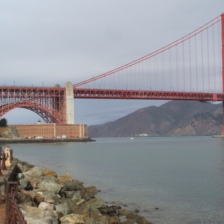

Here's my top guesses of where such place belongs:
['Golden Gate Bridge', 'Forth Bridge', 'Brooklyn Bridge']


In [25]:
def visualize_transformed_img(img_path):
    im=Image.open(img_path)
    tr = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224)
    ])
    im=tr(im)
    display(im)

def suggest_locations(img_path):
    
    ## TODO: display image and display landmark predictions
    print("Let me analyze the following image:")
    visualize_transformed_img(img_path)
    
    print("Here's my top guesses of where such place belongs:")
    
    # get landmark predictions
    top_guess=predicted_landmarks = predict_landmarks(img_path, 3)
    print(top_guess)
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The algorithm is running as expected, maybe a little better. With only 6 epochs the model reached 92% which is way higher than the expected benchmark of 60%. As points of improvement:
- Test transfer learning using more SoTA models like EfficientNet
- Unfreeze the conv layers and train a little more
- Experiment with data augmentation techniques like Mixup

In [26]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# Since I don't have touristic places in my computer, I will download them from the internet
!wget https://gooutside-static-cdn.akamaized.net/wp-content/uploads/sites/3/2020/07/quando-reabrir-machu-picchu-reduzira-a-capacidade-para-2-244-visitantes-diarios.jpg -O 'machupicchu.jpg'

--2021-04-04 17:16:08--  https://gooutside-static-cdn.akamaized.net/wp-content/uploads/sites/3/2020/07/quando-reabrir-machu-picchu-reduzira-a-capacidade-para-2-244-visitantes-diarios.jpg
Resolving gooutside-static-cdn.akamaized.net (gooutside-static-cdn.akamaized.net)... 23.35.70.49, 23.35.70.75, 2600:1407:21::17d7:6971, ...
Connecting to gooutside-static-cdn.akamaized.net (gooutside-static-cdn.akamaized.net)|23.35.70.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘machupicchu.jpg’

machupicchu.jpg         [ <=>                ]   1.13M  --.-KB/s    in 0.05s   

2021-04-04 17:16:08 (24.2 MB/s) - ‘machupicchu.jpg’ saved [1189817]



Let me analyze the following image:


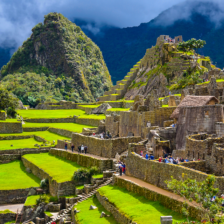

Here's my top guesses of where such place belongs:
['Machu Picchu', 'Hanging Temple', 'Eiffel Tower']


In [27]:
suggest_locations('machupicchu.jpg')

In [28]:
!wget https://i.ytimg.com/vi/brZzLyzaXbA/maxresdefault.jpg -O 'badlands.jpg'

--2021-04-04 17:16:09--  https://i.ytimg.com/vi/brZzLyzaXbA/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 173.194.194.119, 2607:f8b0:4001:c10::77
Connecting to i.ytimg.com (i.ytimg.com)|173.194.194.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147180 (144K) [image/jpeg]
Saving to: ‘badlands.jpg’

badlands.jpg        100%[===================>] 143.73K  --.-KB/s    in 0.002s  

2021-04-04 17:16:09 (69.7 MB/s) - ‘badlands.jpg’ saved [147180/147180]



Let me analyze the following image:


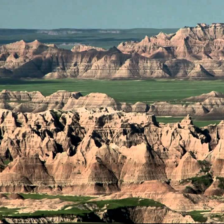

Here's my top guesses of where such place belongs:
['Badlands National Park', 'Grand Canyon', 'Externsteine']


In [29]:
suggest_locations('badlands.jpg')

In [30]:
!wget https://greatruns.com/wp-content/uploads/2017/12/Haleakala-National-Park-700x400.jpg -O 'haleakala.jpg'

--2021-04-04 17:16:10--  https://greatruns.com/wp-content/uploads/2017/12/Haleakala-National-Park-700x400.jpg
Resolving greatruns.com (greatruns.com)... 67.225.241.13
Connecting to greatruns.com (greatruns.com)|67.225.241.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79347 (77K) [image/jpeg]
Saving to: ‘haleakala.jpg’

haleakala.jpg       100%[===================>]  77.49K  --.-KB/s    in 0.03s   

2021-04-04 17:16:10 (2.26 MB/s) - ‘haleakala.jpg’ saved [79347/79347]



Let me analyze the following image:


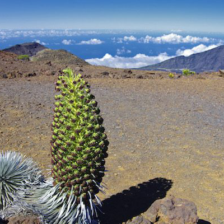

Here's my top guesses of where such place belongs:
['Haleakala National Park', 'Machu Picchu', 'Mount Rainier National Park']


In [31]:
suggest_locations('haleakala.jpg')

In [32]:
!wget https://velvetescape.com/wp-content/uploads/2018/07/IMG_3666-1280x920.jpg -O 'iguazufalls.jpg'

--2021-04-04 17:16:11--  https://velvetescape.com/wp-content/uploads/2018/07/IMG_3666-1280x920.jpg
Resolving velvetescape.com (velvetescape.com)... 172.67.128.137, 104.21.1.49, 2606:4700:3035::6815:131, ...
Connecting to velvetescape.com (velvetescape.com)|172.67.128.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196943 (192K) [image/jpeg]
Saving to: ‘iguazufalls.jpg’

iguazufalls.jpg     100%[===================>] 192.33K  --.-KB/s    in 0.03s   

2021-04-04 17:16:11 (6.08 MB/s) - ‘iguazufalls.jpg’ saved [196943/196943]



Let me analyze the following image:


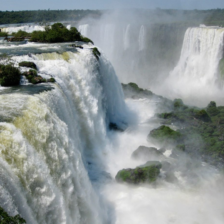

Here's my top guesses of where such place belongs:
['Gullfoss Falls', 'Niagara Falls', 'Yellowstone National Park']


In [33]:
suggest_locations('iguazufalls.jpg')

In [3]:
!jupyter nbconvert --to html landmark.ipynb

[NbConvertApp] Converting notebook landmark.ipynb to html
[NbConvertApp] Writing 5051170 bytes to landmark.html
